## Import library

In [1]:
import sys

MAIN_PATH = "/home/trduong/Data/interpretable_machine_learning/Source Code/my_work"


sys.path.insert(
    1,
    MAIN_PATH + '/lib'
)

sys.path.insert(
    1,
    MAIN_PATH + '/config'
)

import numpy as np
import pandas as pd
import logging
import incremental_ps_score_estimator as ipse
import math
import timeit
import utils
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import KFold
import experiment_config as cf

import dowhy.datasets
import dowhy
from dowhy import CausalModel
import matplotlib.pyplot as plt

from econml.drlearner import ForestDRLearner, LinearDRLearner
from econml.metalearners import SLearner, XLearner, TLearner
from econml.ortho_forest import CausalTree, ContinuousTreatmentOrthoForest, DiscreteTreatmentOrthoForest
from econml.dml import ForestDMLCateEstimator, LinearDMLCateEstimator, SparseLinearDMLCateEstimator
from econml.inference import BootstrapInference
from econml.sklearn_extensions.linear_model import WeightedLasso, WeightedLassoCV

### Import sklearn
from scipy.stats import sem
import scipy.stats as st
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LassoCV, ElasticNetCV
from bartpy.sklearnmodel import SklearnModel


from zepid.causal.doublyrobust import TMLE
from cforest.forest import CausalForest


/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load data

In [2]:
figure_path = "/home/dtd/Documents/PhD_Life/Source Code/my_work/figure"

In [3]:
file_path = "https://msalicedatapublic.blob.core.windows.net/datasets/Pricing/pricing_sample.csv"
train_data = pd.read_csv(file_path)

In [4]:
train_data.price.value_counts()

1.0    4346
0.8    3089
0.9    2565
Name: price, dtype: int64

In [5]:
train_data.shape

In [6]:
train_data['treatment'] = np.where(train_data['price'] == 1, 1, 0)
train_data['price'] = np.where(train_data['price'] == 1, 1, 0.85)

In [7]:
train_data.price.value_counts()

0.85    5654
1.00    4346
Name: price, dtype: int64

In [8]:
train_data.head()

,account_age,age,avg_hours,days_visited,friends_count,has_membership,is_US,songs_purchased,income,price,demand,treatment
0,3,53,1.834234,2,8,1,1,4.903237,0.960863,1.00,3.917117,1
1,5,54,7.171411,7,9,0,1,3.330161,0.732487,1.00,11.585706,1
2,3,33,5.351920,6,9,0,1,3.036203,1.130937,1.00,24.675960,1
3,2,34,6.723551,0,8,0,1,7.911926,0.929197,1.00,6.361776,1
4,4,30,2.448247,5,8,1,0,7.148967,0.533527,0.85,12.624123,0


## Features engineering

In [9]:
outcome = "demand"
treatment = "treatment"
col = list(train_data.columns)
col.remove("price")
print(col)

cov = col[:]
cov.remove(treatment)
cov.remove(outcome)
cov.remove('income')
print(cov)

features = col[:]
features.remove(outcome)

print(features)

['account_age', 'age', 'avg_hours', 'days_visited', 'friends_count', 'has_membership', 'is_US', 'songs_purchased', 'income', 'demand', 'treatment']
['account_age', 'age', 'avg_hours', 'days_visited', 'friends_count', 'has_membership', 'is_US', 'songs_purchased']
['account_age', 'age', 'avg_hours', 'days_visited', 'friends_count', 'has_membership', 'is_US', 'songs_purchased', 'income', 'treatment']


In [10]:
result_dic = {
    'ortho_train':0,
    'ortho_test':0,
    'linear_dr_train':0,
    'linear_dr_test':0,
    'forest_dr_train':0,
    'forest_dr_test':0,
    'incremental_train':0,
    'incremental_test':0,
    'causal_forest_train':0,
    'causal_forest_test':0,
    'tmle_train':0,
    'tmle_test':0,
    'knn_train':0,
    'knn_test':0,
    'ps_train':0,
    'ps_test':0,
    'lr_train':0,
    'lr_test':0,
    'bart_train':0,
    'bart_test':0,
}


## Synthesis function

In [11]:
# Define underlying treatment effect function given DGP
def gamma_fn(X):
    return -3 - 14 * (X["income"] < 1)

def beta_fn(X):
    return 20 + 0.5 * (X["avg_hours"]) + 5 * (X["days_visited"] > 4)

def demand_fn(data, T):
    Y = gamma_fn(data) * T + beta_fn(data)
    return Y

def true_te(x, n, stats):
    if x < 1:
        subdata = train_data[train_data["income"] < 1].sample(n=n, replace=True)
    else:
        subdata = train_data[train_data["income"] >= 1].sample(n=n, replace=True)
    te_array = subdata["price"] * gamma_fn(subdata) / (subdata["demand"])
    if stats == "mean":
        return np.mean(te_array)
    elif stats == "median":
        return np.median(te_array)
    elif isinstance(stats, int):
        return np.percentile(te_array, stats)

## Estimation effect with incremental propensity score

### Estimation effect in train-test

In [12]:
train, test = train_test_split(train_data, test_size=0.3, random_state = 1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
## Fit treatment
model_t = LogisticRegression()
model_t.fit(train[cov], train[treatment])

train['p1'] = model_t.predict_proba(train[cov])[:,1]
train['p0'] = 1 - train['p1']

train["prediction"] = np.where(train["p1"] >= 0.5, 1, 0)
acc = accuracy_score(train["prediction"], train["treatment"])
print("Accuracy score of train data {}".format(acc))

## Fit outcome
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 5000)
model_y.fit(train[features], train[outcome])


Accuracy score of train data 0.5648571428571428


GradientBoostingRegressor(n_estimators=5000, random_state=0)

In [13]:
delta = 2.0

te_array = test["price"] * gamma_fn(test) / (test["demand"])
true_effect_test = np.mean(te_array)

te_array = train["price"] * gamma_fn(train) / (train["demand"])
true_effect_train = np.mean(te_array)

influence = ipse.influence_function(train, treatment, cov, outcome, features, delta, model_y, model_t)
means_incre_train, stds_incre = np.mean(influence, axis=0), sem(influence, axis=0)

influence = ipse.influence_function(test, treatment, cov, outcome, features, delta, model_y, model_t)
means_incre_test, stds_incre = np.mean(influence, axis=0), sem(influence, axis=0)

origin_mae_train = utils.abs_ate(true_effect_train, means_incre_train)
origin_mae_test = utils.abs_ate(true_effect_test, means_incre_test)


## Optimization with single delta

In [14]:
def incre_ps(delta, data):
    q1 = (delta * data['p1']) / (delta * data['p1'] + data['p0'])
    q1 = tf.math.abs(q1)
    a0 = (1-q1)*data['w0']*(data['cf0'] - data[outcome])
    a1 = q1*data['w1']*(data['cf1'] - data[outcome])    
    influence = a1 - a0
    return tf.reduce_mean(influence), influence

def optimization(train, test, true_effect):
    threhold = tf.constant([0.001])
    delta = tf.Variable(np.random.randint(low=1, high=100, size=1), 
                        trainable = True, 
                        dtype = tf.float32)
    delta_seq = []
    losses = []
    losses_test = []
    effects_train = []
    effects_test = []
    influences_train = []
    influences_test = []
    for i in tqdm(range(10000)):
        with tf.GradientTape() as tape:
            mu_influence_train, influence_train = incre_ps(delta, train)
            mu_influence_test, influence_test = incre_ps(delta, test)
            loss = tf.math.abs(true_effect - mu_influence_train)
            loss_test = tf.math.abs(true_effect - mu_influence_test)
            d_delta = tape.gradient(loss, delta)
            opt = tf.keras.optimizers.Adam(learning_rate=0.01)
            opt.apply_gradients(zip([d_delta], [delta]))
            ## early stopping 
            if tf.math.less(loss, threhold):
                print("The performance reach MAE: 0.001. Cancelling the training at step {}".format(i))
                break
            delta_seq.append(delta.numpy())
            losses.append(loss.numpy())
            losses_test.append(loss_test.numpy())
            effects_train.append(mu_influence_train.numpy())
            effects_test.append(mu_influence_test.numpy())
            influences_train.append(influence_train.numpy())
            influences_test.append(influence_test.numpy())
        if i % 1000 == 0:
            print("Epoch {}. Loss {:.4f}".format(i, loss))
    print("Loss {:.3f}".format(loss))
    return delta, delta_seq, losses, losses_test, influences_train, influences_test

In [15]:
te_array = train["price"] * gamma_fn(train) / (train["demand"])
true_effect = np.mean(te_array)
delta, delta_seq, losses, losses_test, influences_train, influences_test = optimization(train, test, true_effect)

  0%|          | 27/10000 [00:00<01:20, 124.01it/s]

Epoch 0. Loss 1.1213


 10%|█         | 1025/10000 [00:08<01:11, 125.19it/s]

Epoch 1000. Loss 1.1013


 20%|██        | 2016/10000 [00:15<01:03, 126.46it/s]

Epoch 2000. Loss 1.0512


 30%|███       | 3020/10000 [00:23<00:55, 125.25it/s]

Epoch 3000. Loss 0.7009


 40%|████      | 4026/10000 [00:32<00:47, 125.94it/s]

Epoch 4000. Loss 0.0026


 50%|█████     | 5017/10000 [00:40<00:39, 126.67it/s]

Epoch 5000. Loss 0.0026


 60%|██████    | 6017/10000 [00:48<00:35, 111.71it/s]

Epoch 6000. Loss 0.0026


 70%|███████   | 7020/10000 [00:57<00:23, 128.96it/s]

Epoch 7000. Loss 0.0026


 80%|████████  | 8024/10000 [01:05<00:16, 120.69it/s]

Epoch 8000. Loss 0.0026


 90%|█████████ | 9024/10000 [01:13<00:08, 114.16it/s]

Epoch 9000. Loss 0.0026


100%|██████████| 10000/10000 [01:21<00:00, 122.07it/s]

Loss 0.006


In [16]:
losses[-1]

0.0061950684

In [17]:
te_array = test["price"] * gamma_fn(test) / (test["demand"])
true_effect_test = np.mean(te_array)

te_array = train["price"] * gamma_fn(train) / (train["demand"])
true_effect_train = np.mean(te_array)

mean_train = np.mean(influences_train[-1])
mean_test = np.mean(influences_test[-1])

optimal_mae_train = utils.abs_ate(true_effect_train, mean_train)
optimal_mae_test = utils.abs_ate(true_effect_test, mean_test)

In [18]:
result_dic['incremental_train'] = optimal_mae_train
result_dic['incremental_test'] = optimal_mae_test

## Conclusion

In [19]:
print("Before Optimization")
print("MAE on training {} and testing {}".format(origin_mae_train, origin_mae_test))
print("After Optimization")
print("MAE on training {} and testing {}".format(optimal_mae_train, optimal_mae_test))


Before Optimization
MAE on training 0.6973648076930858 and testing 0.7116199006600928
After Optimization
MAE on training 0.006195336129333429 and testing 0.04070933945626465


## Confidence interval

In [20]:
lowers_train, uppers_train = [], []
lowers_test, uppers_test = [], []
means_train, means_test = [], []

for i in tqdm(range(len(delta_seq))):

    mean_train, mean_test = np.mean(influences_train[i]), np.mean(influences_test[i])
    stds_incre_train, stds_incre_test = sem(influences_train[i], axis=0), sem(influences_test[i], axis=0)

    lower_train, upper_train = st.t.interval(0.90, 
                                         len(influences_train[i])-1, 
                                         loc=mean_train, 
                                         scale=stds_incre_train)
    lower_test, upper_test = st.t.interval(0.90, 
                                             len(influences_test[i])-1, 
                                             loc=mean_test, 
                                             scale=stds_incre_test)
    

    lowers_train.append(lower_train)
    uppers_train.append(upper_train)
    lowers_test.append(lower_test)
    uppers_test.append(upper_test)
    means_train.append(mean_train)
    means_test.append(mean_test)

100%|██████████| 10000/10000 [00:10<00:00, 920.24it/s]


In [21]:
len(uppers_train), len(lowers_train), len(delta_seq), len(means_train)

In [22]:
lowers_train = np.array(lowers_train)
uppers_train = np.array(uppers_train)
delta_seq = np.array(delta_seq)

In [23]:
lowers_train[0], uppers_train[0]

In [24]:
delta_seq = delta_seq.reshape(-1)

In [25]:
delta_seq[-1]

0.025010578

In [26]:
lowers_train.shape, uppers_train.shape, delta_seq.shape

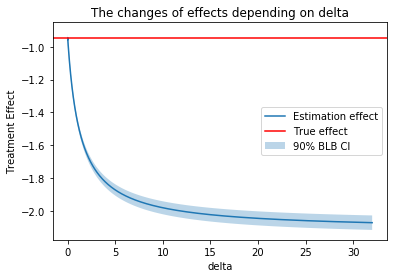

In [27]:
fig = plt.figure()
plt.plot(delta_seq, means_train, label='Estimation effect')
plt.axhline(y=true_effect_train, color='r', linestyle='-', label = "True effect")
plt.fill_between(delta_seq, lowers_train, uppers_train, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("delta")
plt.title("The changes of effects depending on delta")
plt.legend()
plt.show()
fig.savefig(cf.FIGURE_PATH + '/demand_train.png')


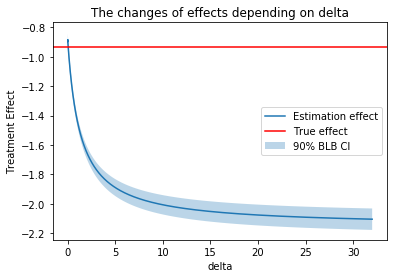

In [28]:
fig = plt.figure()
plt.plot(delta_seq, means_test, label='Estimation effect')
plt.axhline(y=true_effect_test, color='r', linestyle='-', label = "True effect")
plt.fill_between(delta_seq, lowers_test, uppers_test, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("delta")
plt.title("The changes of effects depending on delta")
plt.legend()
plt.show()
fig.savefig(cf.FIGURE_PATH + '/demand_test.png')


## Compare with other method

### BART

In [29]:
def causal_bart(data, bart_model):
    data_pos = data.copy()
    data_pos[treatment] = 1
    data['treated_cf_outcome'] = bart_model.predict(data_pos[features])

    ## Compute counterfactual outcome with treatment
    data_neg = data.copy()
    data_neg[treatment] = 0
    data['control_cf_outcome'] = bart_model.predict(data_neg[features])
    
    return np.mean(data['treated_cf_outcome'] - data['control_cf_outcome'])

In [30]:
bart_model = SklearnModel() # Use default parameters
bart_model.fit(train[features].values, train[outcome].values)

effects_train = causal_bart(train, bart_model)
effects_test = causal_bart(test, bart_model)

mae_bart_train = utils.abs_ate(true_effect_train, effects_train)
mae_bart_test = utils.abs_ate(true_effect_test, effects_test)



In [31]:
print("BART on training {:.4f} an testing {:.4f}".format(mae_bart_train, mae_bart_test))

result_dic['bart_train'] = mae_bart_train
result_dic['bart_test'] = mae_bart_test

BART on training 0.5105 an testing 0.5237


### K-nn and Linear Regression

In [47]:
model = CausalModel(data=train,
                    treatment=treatment,
                    outcome=outcome,
                    common_causes=cov, proceed_when_unidentifiable=True)
train[treatment] = [bool(x) for x in train[treatment]]
identified_estimand = model.identify_effect()

estimate_we = model.estimate_effect(
        identified_estimand, method_name="backdoor.propensity_score_matching")

estimate_linear = model.estimate_effect(
        identified_estimand, method_name="backdoor.linear_regression")


model = CausalModel(data=test,
                    treatment=treatment,
                    outcome=outcome,
                    common_causes=cov, proceed_when_unidentifiable=True)
test[treatment] = [bool(x) for x in test[treatment]]
identified_estimand = model.identify_effect()

estimate_we_test = model.estimate_effect(
    identified_estimand, method_name="backdoor.propensity_score_matching")

estimate_linear_test = model.estimate_effect(
        identified_estimand, method_name="backdoor.linear_regression")

knn_train = utils.abs_ate(true_effect_train, estimate_we.value)
knn_test = utils.abs_ate(true_effect_test, estimate_we_test.value)

lr_train = utils.abs_ate(true_effect_train, estimate_linear.value)
lr_test = utils.abs_ate(true_effect_test, estimate_linear_test.value)

print(lr_train, lr_test)

result_dic['knn_train'] = knn_train
result_dic['knn_test'] = knn_test

result_dic['lr_train'] = lr_train
result_dic['lr_test'] = lr_test

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['treatment'] on outcome ['demand']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['songs_purchased', 'avg_hours', 'age', 'U', 'days_visited', 'is_US', 'friends_count', 'account_age', 'has_membership']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: demand~treatment+songs_purchased+avg_hours+age+days_visited+is_US+friends_count+account_age+has_membership
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.p

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     268.8
Date:                Wed, 15 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:55:07   Log-Likelihood:                -22086.
No. Observations:                7000   AIC:                         4.419e+04
Df Residuals:                    6990   BIC:                         4.426e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1179      0.496     16.378      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: demand~treatment+songs_purchased+avg_hours+age+days_visited+is_US+friends_count+account_age+has_membership


                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     136.2
Date:                Wed, 15 Jul 2020   Prob (F-statistic):          1.19e-215
Time:                        19:55:09   Log-Likelihood:                -9369.4
No. Observations:                3000   AIC:                         1.876e+04
Df Residuals:                    2990   BIC:                         1.882e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6608      0.726      9.177      0.0

### TMLE

In [36]:
cov, features

(['account_age',
  'age',
  'avg_hours',
  'days_visited',
  'friends_count',
  'has_membership',
  'is_US',
  'songs_purchased'],
 ['account_age',
  'age',
  'avg_hours',
  'days_visited',
  'friends_count',
  'has_membership',
  'is_US',
  'songs_purchased',
  'income',
  'treatment'])

In [37]:
train.head()

,account_age,age,avg_hours,days_visited,friends_count,has_membership,is_US,songs_purchased,income,price,...,q1,q0,ips_weight,w0,w1,a0,a1,treated_cf_outcome,control_cf_outcome,propensity_score
0,1,24,9.248883,3,9,0,1,3.811846,0.910882,0.85,...,0.602518,0.397482,1.757920,0.000000,1.757920,0.000000,-2.657012,7.764551,10.534841,0.431146
1,5,44,4.749626,3,10,1,1,0.946969,0.947821,0.85,...,0.602466,0.397534,1.757753,0.000000,1.757753,-0.000000,-3.010740,5.528111,8.298402,0.431092
2,5,47,7.314620,5,11,1,1,7.507631,1.146840,1.00,...,0.593373,0.406627,2.370561,2.370561,0.000000,0.430904,0.000000,25.716176,25.980128,0.421841
3,3,34,6.427881,5,9,0,1,2.490809,0.292760,0.85,...,0.616492,0.383508,1.803754,0.000000,1.803754,-0.000000,-3.033217,11.170981,13.941271,0.445601
4,3,52,3.485347,4,6,1,1,4.825241,1.409855,1.00,...,0.609469,0.390531,2.281543,2.281543,0.000000,0.259216,-0.000000,18.571436,18.835388,0.438300


In [38]:
train, test = train_test_split(train_data, test_size=0.3, random_state = 1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

expose_m = ' + '.join(cov)
outcome_m = ' + '.join(features)

model_t = LogisticRegression(penalty='l2', random_state=201)
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 5000)

tml = TMLE(train, exposure=treatment, outcome=outcome)
tml.exposure_model(expose_m, bound=[0.01, 0.99], print_results=False, custom_model=model_t)
tml.outcome_model(outcome_m, print_results=False, custom_model = model_y)
tml.fit()

mae_train = utils.abs_ate(true_effect_train, tml.average_treatment_effect)

tml = TMLE(test, exposure=treatment, outcome=outcome)
tml.exposure_model(expose_m, bound=[0.01, 0.99], print_results=False, custom_model=model_t)
tml.outcome_model(outcome_m, print_results=False)
tml.fit()

mae_test = utils.abs_ate(true_effect_test, tml.average_treatment_effect)


result_dic['tmle_train'] = mae_train
result_dic['tmle_test'] = mae_test


### Causal Forest

In [41]:
cf = CausalForest(
        num_trees=50,
        split_ratio=0.5,
        min_leaf=5,
        max_depth=20,
        use_transformed_outcomes=True,
        num_workers=4,
        seed_counter=1,
    )

train['term_t'] = train[treatment].apply(lambda x: bool(x))
test['term_t'] = test[treatment].apply(lambda x: bool(x))
    
    
cf = cf.fit(train[features].values, train['term_t'].values, train[outcome].values)

cf_train = np.mean(cf.predict(train[features].values))
cf_test = np.mean(cf.predict(test[features].values))

mae_train = utils.abs_ate(true_effect_train, cf_train)
mae_test = utils.abs_ate(true_effect_test, cf_test)


In [45]:
result_dic['causal_forest_train'] = mae_train
result_dic['causal_forest_test'] = mae_test

### Ortho

In [50]:
train, test = train_test_split(train_data, test_size=0.3, random_state = 1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [53]:
## Linear
est = LinearDRLearner(model_propensity=GradientBoostingClassifier(),
                      model_regression=GradientBoostingRegressor())
est.fit(Y = train[outcome].values, T = train[treatment].values, X = train[features].values, inference='statsmodels')
ate_dr_train = np.mean(est.effect(train[features].values))
ate_dr_test = np.mean(est.effect(test[features].values))

## Forest
est = ForestDRLearner(model_propensity=GradientBoostingClassifier(),
                  model_regression=GradientBoostingRegressor())
est.fit(Y = train[outcome].values, T = train[treatment].values, X = train[features].values, inference='blb')
ate_fdr_train = np.mean(est.effect(train[features].values))
ate_fdr_test = np.mean(est.effect(test[features].values))


est = DiscreteTreatmentOrthoForest(n_trees=500,
                               model_Y = WeightedLasso(alpha=0.5))

est.fit(Y = train[outcome].values, T = train[treatment].values, X = train[features].values, inference='blb')

ate_ortho_train = np.mean(est.effect(train[features].values))
ate_ortho_test = np.mean(est.effect(test[features].values))


ortho_train = utils.abs_ate(means, ate_ortho_train)
dr_train = utils.abs_ate(means, ate_dr_train)
fdr_train = utils.abs_ate(means, ate_fdr_train)

ortho_test = utils.abs_ate(means, ate_ortho_test)
dr_test = utils.abs_ate(means, ate_dr_test)
fdr_test = utils.abs_ate(means, ate_fdr_test)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was rea

/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   58.

/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-pack

/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-pack

/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-pack

/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    9.7s
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning

/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:  1.3min
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarnin

/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.8min finished


NameError: name 'means' is not defined

## Conclusion

In [48]:
result_dic

{'ortho_train': 0,
 'ortho_test': 0,
 'linear_dr_train': 0,
 'linear_dr_test': 0,
 'forest_dr_train': 0,
 'forest_dr_test': 0,
 'incremental_train': 0.006195336129333429,
 'incremental_test': 0.04070933945626465,
 'causal_forest_train': 3.205164470048029,
 'causal_forest_test': 3.184676893105144,
 'tmle_train': 0.6508150081179727,
 'tmle_test': 3.2693873362731893,
 'knn_train': 5.730074732695224,
 'knn_test': 6.1906266773303456,
 'ps_train': 0,
 'ps_test': 0,
 'lr_train': 5.7327172115193,
 'lr_test': 6.3167547942205955,
 'bart_train': 0.5105432324766301,
 'bart_test': 0.5237041549037907}

In [44]:
for k,v in result_dic.items():
    print("Method {}, MAE {:.4f}".format(k,v))

Method ortho_train, MAE 0.0000
Method ortho_test, MAE 0.0000
Method linear_dr_train, MAE 0.0000
Method linear_dr_test, MAE 0.0000
Method forest_dr_train, MAE 0.0000
Method forest_dr_test, MAE 0.0000
Method incremental_train, MAE 0.0062
Method incremental_test, MAE 0.0407
Method causal_forest_train, MAE 3.2052
Method causal_forest_test, MAE 3.1847
Method tmle_train, MAE 0.6508
Method tmle_test, MAE 3.2694
Method knn_train, MAE 5.7301
Method knn_test, MAE 6.1906
Method ps_train, MAE 0.0000
Method ps_test, MAE 0.0000
Method lr_train, MAE 5.7327
Method lr_test, MAE 6.3168
Method bart_train, MAE 0.5105
Method bart_test, MAE 0.5237
